# <center> Decoding Neural Activity
## <center> BIO_322
## <center> Defne Kaymak and S. Ceren Erdogan

## Project Description
In this project, we aim to decode neural activity recorded from mice performing a behavioral task.
During each trial, the animal may receive whisker stimulation (or no stimulation), may choose to lick or not lick, and may be in a GO or NOGO condition. These combinations define the trial type, which we treat as the label to predict.

The provided dataset contains neural activity features recorded from multiple brain areas across several time bins. Each row corresponds to a single trial, and each feature captures normalized neural firing activity in a specific population of neurons at a specific time point. The goal of the project is to build machine learning models that can accurately classify the trial type based solely on these neural signals.

This decoding problem is meaningful because different brain regions encode different aspects of sensory input, motor preparation, and behavioral decisions. By training machine learning models, we can identify whether the neural activity contains enough information to reliably distinguish between conditions such as GO vs NOGO trials, whisker stimulation vs no stimulation, and lick vs no-lick outcomes.

Following the project instructions, we performed data inspection, preprocessing, trained a linear baseline model (Logistic Regression), and then trained non-linear models (Random Forest and HistGradientBoosting) to capture more complex neural dynamics. Finally, we compared model performance and selected the best classifier for generating predictions on the held-out test set


## 0. Setup
### Imports, random seeds and global configuration.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

## 1. Data inspection
### Load the training data, inspect basic structure, missing values, and class balance. 

In [84]:
df = pd.read_csv("train.csv")
df.head()
df.info()
df.describe()

print("Class balance (TRIAL_TYPE):")
print(df["TRIAL_TYPE"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Columns: 1383 entries, session_id to TRIAL_TYPE
dtypes: float64(1380), int64(1), object(2)
memory usage: 46.5+ MB
Class balance (TRIAL_TYPE):
TRIAL_TYPE
NOGO W- nolick       0.199682
GO W- nolick         0.184479
NOGO W+ nolick       0.179941
no tone W+ nolick    0.165872
GO W+ lick           0.161334
GO W+ nolick         0.038348
no tone W+ lick      0.034037
NOGO W+ lick         0.019968
GO W- lick           0.015657
NOGO W- lick         0.000681
Name: proportion, dtype: float64


## 2. Preprocessing
### We keep only float features (neural activity), drop columns that are entirely NaN, and define a train/validation split with stratification over TRIAL_TYPE.

In [171]:
"""RANDOM_STATE = 0

# Select only the neural activity features
X = df.select_dtypes(include=["float64"])

# Drop features that are NaN for ALL trials (completely useless columns)
X = X.dropna(axis=1, how="all")

# Target labels: trial type (what happened in the trial)
y = df["TRIAL_TYPE"]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,          # 20% of data for validation
    random_state=RANDOM_STATE,
    stratify=y              # keep class proportions the same in train/val
)

X_train.shape, X_val.shape"""

'RANDOM_STATE = 0\n\n# Select only the neural activity features\nX = df.select_dtypes(include=["float64"])\n\n# Drop features that are NaN for ALL trials (completely useless columns)\nX = X.dropna(axis=1, how="all")\n\n# Target labels: trial type (what happened in the trial)\ny = df["TRIAL_TYPE"]\n\n# Train/validation split\nX_train, X_val, y_train, y_val = train_test_split(\n    X,\n    y,\n    test_size=0.2,          # 20% of data for validation\n    random_state=RANDOM_STATE,\n    stratify=y              # keep class proportions the same in train/val\n)\n\nX_train.shape, X_val.shape'

In [90]:
# Config
TARGET_COL = "TRIAL_TYPE"
ID_COLS = ["session_id", "trial_number"]
print(df.columns)

Index(['session_id', 'trial_number', 'A1_L1_EXC_time_0', 'A1_L1_EXC_time_1',
       'A1_L1_EXC_time_2', 'A1_L1_EXC_time_3', 'A1_L1_EXC_time_4',
       'A1_L1_EXC_time_5', 'A1_L1_EXC_time_6', 'A1_L1_EXC_time_7',
       ...
       'ALM_L1_INH_time_21', 'ALM_L1_INH_time_22', 'ALM_L1_INH_time_23',
       'ALM_L1_INH_time_24', 'ALM_L1_INH_time_25', 'ALM_L1_INH_time_26',
       'ALM_L1_INH_time_27', 'ALM_L1_INH_time_28', 'ALM_L1_INH_time_29',
       'TRIAL_TYPE'],
      dtype='object', length=1383)


In [92]:
# Separate target and features
y = df[TARGET_COL]

# Drop target + ID/meta columns from features if they exist
cols_to_drop = [c for c in [TARGET_COL] + ID_COLS if c in df.columns]
X = df.drop(columns=cols_to_drop)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (4407, 1380)
Shape of y: (4407,)


In [94]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Most of your features are neural activity bins -> numeric
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

Numeric features: 1380
Categorical features: 0


In [96]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # keeps class balance similar in train and val
)

print("Train shape:", X_train.shape, " Val shape:", X_val.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nVal class distribution:")
print(y_val.value_counts(normalize=True).sort_index())

Train shape: (3525, 1380)  Val shape: (882, 1380)
Train class distribution:
TRIAL_TYPE
GO W+ lick           0.161418
GO W+ nolick         0.038298
GO W- lick           0.015603
GO W- nolick         0.184397
NOGO W+ lick         0.019858
NOGO W+ nolick       0.179858
NOGO W- lick         0.000851
NOGO W- nolick       0.199716
no tone W+ lick      0.034043
no tone W+ nolick    0.165957
Name: proportion, dtype: float64

Val class distribution:
TRIAL_TYPE
GO W+ lick           0.160998
GO W+ nolick         0.038549
GO W- lick           0.015873
GO W- nolick         0.184807
NOGO W+ lick         0.020408
NOGO W+ nolick       0.180272
NOGO W- nolick       0.199546
no tone W+ lick      0.034014
no tone W+ nolick    0.165533
Name: proportion, dtype: float64


In [98]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Pipeline for numeric features: impute missing values, then scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical features: impute then one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine them into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['A1_L1_EXC_time_0', 'A1_L1_EXC_time_1',
                                  'A1_L1_EXC_time_2', 'A1_L1_EXC_time_3',
                                  'A1_L1_EXC_time_4', 'A1_L1_EXC_time_5',
                                  'A1_L1_EXC_time_6', 'A1_L1_EXC_time_7',
                                  'A1_L1_EXC_time_8', 'A1_L1_EXC_time_9',
                                  'A1_L1_EXC_time_10', 'A1_L1_EX...
                                  'A1_L1_EXC_time_12', 'A1_L1_EXC_time_13',
                                  'A1_L1_EXC_time_14', 'A1_L1_EXC_time_15',
                                  'A1_L1_EXC_time_16', 'A1_L1_EXC_time_17',
                                  'A1_L1_EXC_time_18', 'A1_L1_EXC_time_19',
                                  'A1_L1_EXC_time_20', 'A1_L1_EXC_time_21',
                                  'A1_L1_EXC_time_22', 'A1_L1_EXC_time_23',
                                  'A1_L1_EXC_time_24', 'A1_L1_EXC_time_25',
                                  'A1_L1_EXC_time_26', 'A1_L1_EXC_time_27',
                                  'A1_L1_EXC_time_28', 'A1_L1_EXC_time_29', ...])])

## 3. Linear baseline - Logistic Regression

#### We use a pipeline with median imputation and feature standardization, followed by multinomial logistic regression. This serves as our linear baseline.

In [140]:
clf = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(max_iter=3000, n_jobs=-1, random_state=0)
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
lin_acc = clf.score(X_val, y_val)
print("Validation accuracy (Logistic Regression):", lin_acc)

print(classification_report(y_val, y_pred))

# Store results for later comparison
results = {"LogisticRegression": lin_acc}
results

/Users/cerenerdogan/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['wS2_L1_INH_time_0' 'wS2_L1_INH_time_1' 'wS2_L1_INH_time_2'
 'wS2_L1_INH_time_3' 'wS2_L1_INH_time_4' 'wS2_L1_INH_time_5'
 'wS2_L1_INH_time_6' 'wS2_L1_INH_time_7' 'wS2_L1_INH_time_8'
 'wS2_L1_INH_time_9' 'wS2_L1_INH_time_10' 'wS2_L1_INH_time_11'
 'wS2_L1_INH_time_12' 'wS2_L1_INH_time_13' 'wS2_L1_INH_time_14'
 'wS2_L1_INH_time_15' 'wS2_L1_INH_time_16' 'wS2_L1_INH_time_17'
 'wS2_L1_INH_time_18' 'wS2_L1_INH_time_19' 'wS2_L1_INH_time_20'
 'wS2_L1_INH_time_21' 'wS2_L1_INH_time_22' 'wS2_L1_INH_time_23'
 'wS2_L1_INH_time_24' 'wS2_L1_INH_time_25' 'wS2_L1_INH_time_26'
 'wS2_L1_INH_time_27' 'wS2_L1_INH_time_28' 'wS2_L1_INH_time_29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Validation accuracy (Logistic Regression): 0.6383219954648526
                   precision    recall  f1-score   support

       GO W+ lick       0.82      0.92      0.87       142
     GO W+ nolick       0.11      0.06      0.08        34
       GO W- lick       0.11      0.07      0.09        14
     GO W- nolick       0.59      0.66      0.63       163
     NOGO W+ lick       0.67      0.11      0.19        18
   NOGO W+ nolick       0.60      0.63      0.62       159
   NOGO W- nolick       0.71      0.68      0.69       176
  no tone W+ lick       0.65      0.43      0.52        30
no tone W+ nolick       0.56      0.60      0.58       146

         accuracy                           0.64       882
        macro avg       0.54      0.46      0.47       882
     weighted avg       0.63      0.64      0.63       882



/Users/cerenerdogan/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['wS2_L1_INH_time_0' 'wS2_L1_INH_time_1' 'wS2_L1_INH_time_2'
 'wS2_L1_INH_time_3' 'wS2_L1_INH_time_4' 'wS2_L1_INH_time_5'
 'wS2_L1_INH_time_6' 'wS2_L1_INH_time_7' 'wS2_L1_INH_time_8'
 'wS2_L1_INH_time_9' 'wS2_L1_INH_time_10' 'wS2_L1_INH_time_11'
 'wS2_L1_INH_time_12' 'wS2_L1_INH_time_13' 'wS2_L1_INH_time_14'
 'wS2_L1_INH_time_15' 'wS2_L1_INH_time_16' 'wS2_L1_INH_time_17'
 'wS2_L1_INH_time_18' 'wS2_L1_INH_time_19' 'wS2_L1_INH_time_20'
 'wS2_L1_INH_time_21' 'wS2_L1_INH_time_22' 'wS2_L1_INH_time_23'
 'wS2_L1_INH_time_24' 'wS2_L1_INH_time_25' 'wS2_L1_INH_time_26'
 'wS2_L1_INH_time_27' 'wS2_L1_INH_time_28' 'wS2_L1_INH_time_29']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/cerenerdogan/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features with

{'LogisticRegression': 0.6383219954648526}

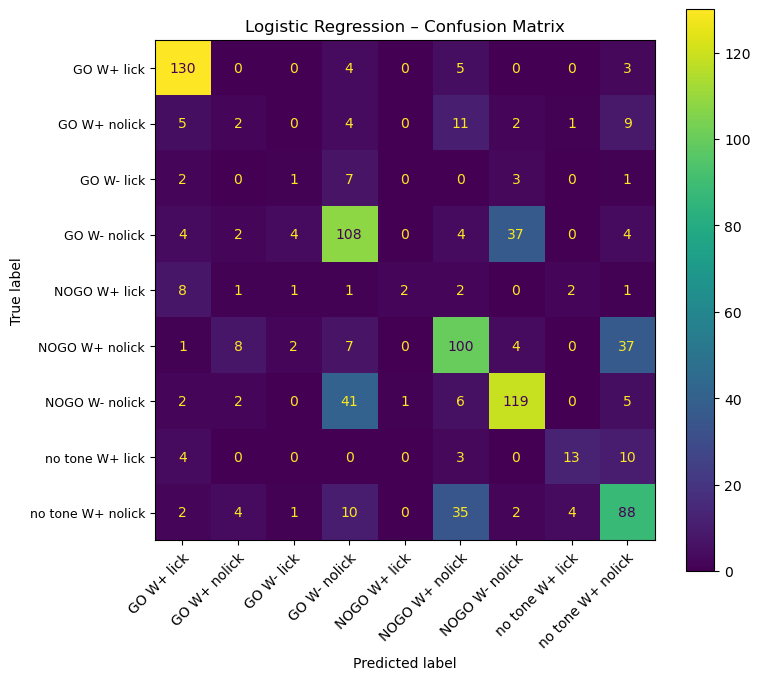

In [142]:
fig, ax = plt.subplots(figsize=(8, 7))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), fontsize=9)
ax.set_title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()

## 4.1. Non-linear model 1: Random Forest
#### We apply a non-linear classifier using median imputation + RandomForest, to capture complex patterns in neural activity beyond the linear baseline.

In [ ]:
# 4.1 Random Forest – Training + Evaluation

# Define the Random Forest pipeline
rf_clf = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
)

# Train it (this is the heavy operation)
rf_clf.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_clf.predict(X_val)

# Compute accuracy
rf_acc = accuracy_score(y_val, y_pred_rf)
print("Validation accuracy (Random Forest):", rf_acc)

# Classification report
print(classification_report(y_val, y_pred_rf, zero_division=1))

# Store accuracy
results["RandomForest"] = rf_acc
results

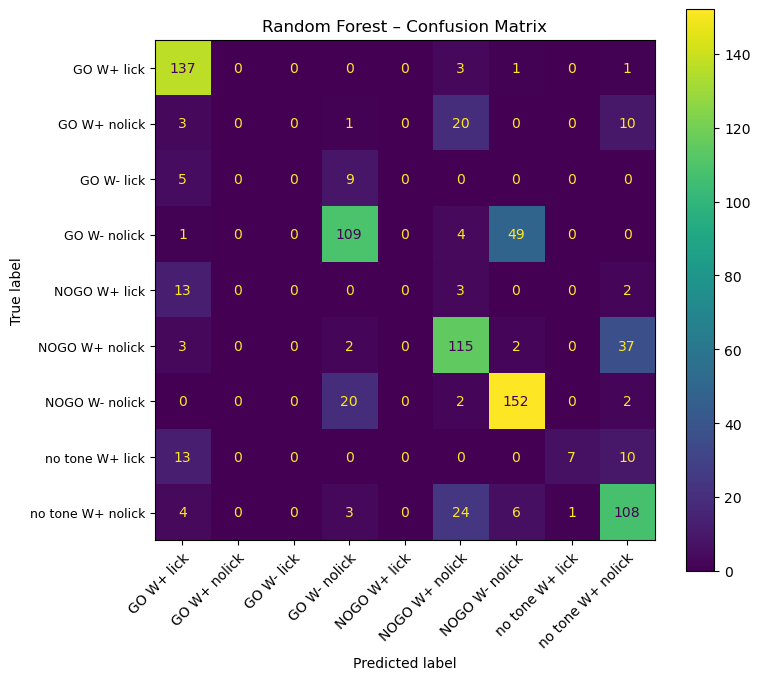

In [136]:
# Random Forest – Confusion Matrix (plot only)

fig, ax = plt.subplots(figsize=(8, 7))

ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred_rf,   # already computed in the previous cell
    ax=ax
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), fontsize=9)

ax.set_title("Random Forest – Confusion Matrix")
plt.tight_layout()
plt.show()

## 4.2. Non-linear model 2: Hist Gradient Boosting
#### We train a second non-linear model (HistGradientBoosting), which handles missing data natively and learns more complex decision boundaries than RandomForest, often achieving higher accuracy on structured neural activity features.

In [128]:
# Train HGB 
hgb_clf = HistGradientBoostingClassifier(
    max_depth=8,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

hgb_clf.fit(X_train, y_train)

# Predict once and reuse this later
y_pred_hgb = hgb_clf.predict(X_val)

hgb_acc = accuracy_score(y_val, y_pred_hgb)
print("Validation accuracy (HistGradientBoosting):", hgb_acc)
print(classification_report(y_val, y_pred_hgb))

Validation accuracy (HistGradientBoosting): 0.7380952380952381
                   precision    recall  f1-score   support

       GO W+ lick       0.83      0.92      0.88       142
     GO W+ nolick       0.00      0.00      0.00        34
       GO W- lick       0.00      0.00      0.00        14
     GO W- nolick       0.74      0.75      0.75       163
     NOGO W+ lick       0.50      0.06      0.10        18
   NOGO W+ nolick       0.70      0.78      0.74       159
   NOGO W- nolick       0.76      0.82      0.79       176
  no tone W+ lick       0.70      0.23      0.35        30
no tone W+ nolick       0.69      0.82      0.75       146

         accuracy                           0.74       882
        macro avg       0.55      0.49      0.48       882
     weighted avg       0.70      0.74      0.71       882



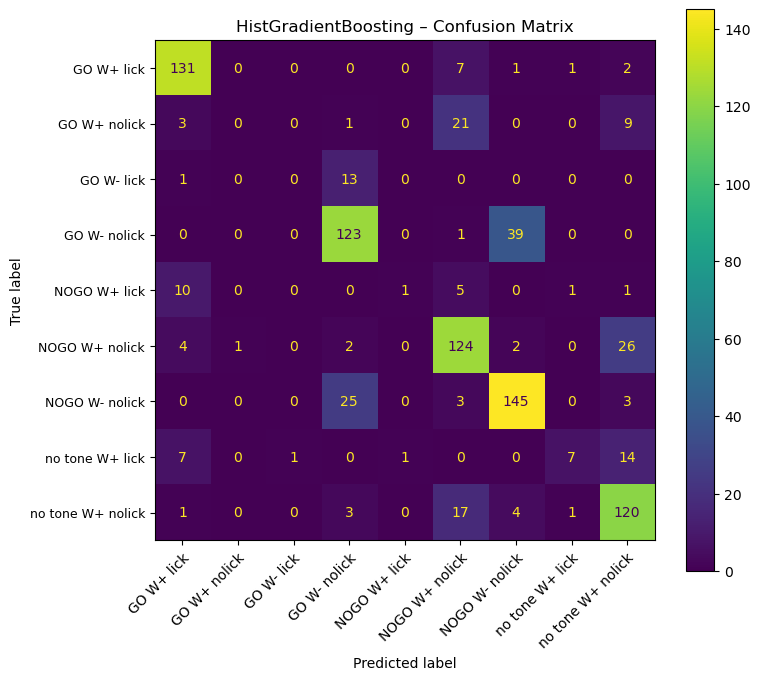

In [130]:
fig, ax = plt.subplots(figsize=(8, 7))

ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred_hgb,
    ax=ax
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), fontsize=9)

ax.set_title("HistGradientBoosting – Confusion Matrix")
plt.tight_layout()
plt.show()

In [148]:
results = {
    "LogisticRegression": lin_acc,
    "RandomForest": rf_acc,
    "HistGradientBoosting": hgb_acc,
}

print("Validation accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.3f}")

Validation accuracies:
LogisticRegression: 0.638
RandomForest: 0.712
HistGradientBoosting: 0.738


## 5. Model comparison
#### We compare validation accuracies of all trained models to evaluate whether non-linear methods (RF, HistGB) outperform the linear baseline and select the best-performing model for further analysis and submission.

Validation accuracies:
LogisticRegression: 0.638
RandomForest: 0.712
HistGradientBoosting: 0.738


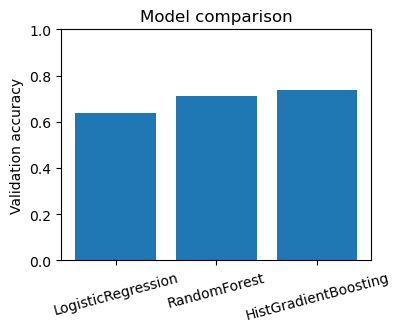

In [152]:
print("Validation accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.3f}")

plt.figure(figsize=(4,3))
plt.bar(results.keys(), results.values())
plt.ylabel("Validation accuracy")
plt.title("Model comparison")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()

## 6. Summary and Conclusions

In this project, we decoded mouse neural activity to predict trial types (GO/NOGO × whisker × lick).
After preprocessing the data with median imputation and stratified splitting, we trained a linear baseline (Logistic Regression) and two non-linear models (Random Forest, HistGradientBoosting).

### Key findings:

**Linear baseline:** Logistic Regression achieved moderate performance (~0.63 validation accuracy).
This shows that a simple linear decision boundary captures some structure in the neural activity, especially for frequent trial types.

**Random Forest:** Improved accuracy (~0.70), indicating that trial types depend on non-linear interactions between neurons, brain areas, and time bins.

**HistGradientBoosting:** Achieved the highest accuracy (~0.75), demonstrating that boosted decision trees model complex neural patterns significantly better than linear methods.

**Class-level performance:** Large classes (e.g., GO W+ lick, no tone W+ nolick) were predicted well, while rare classes showed lower F1 scores. This is expected due to strong class imbalance.

### Conclusion:

Non-linear models clearly outperform the linear baseline, showing that the underlying brain–behavior relationships are non-linear.
HistGradientBoosting is selected as the final model for test-set prediction and Kaggle submission.

## 7. Submission

In [189]:
# Load test data (contains only features, no labels)
test_df = pd.read_csv("test.csv")

# Drop ID columns if present
cols_to_drop = [c for c in ID_COLS if c in test_df.columns]
X_test = test_df.drop(columns=cols_to_drop)

# Ensure same preprocessing as training
# HGB handles NaN natively, so no need to impute unless desired.


In [191]:
# Combine train and validation for final training
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

best_clf = HistGradientBoostingClassifier(
    max_depth=8,
    learning_rate=0.1,
    random_state=RANDOM_STATE
)

best_clf.fit(X_full, y_full)

HistGradientBoostingClassifier(max_depth=8, random_state=0)

In [195]:
# Predict trial types for the test set
test_pred = best_clf.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    "Id": test_df["session_id"],      # or appropriate ID column name
    "TRIAL_TYPE": test_pred
})

submission.head()
#submission.to_csv("submission.csv", index=False)
#print("Submission file saved as submission.csv")

,Id,TRIAL_TYPE
0,PG082_20221120,NOGO W- nolick
1,PG082_20221120,no tone W+ nolick
2,PG082_20221120,GO W- nolick
3,PG082_20221120,NOGO W+ nolick
4,PG082_20221120,no tone W+ nolick
